In [1]:
import pandas as pd
import numpy as np
import semopy

from causalnex.structure.pytorch import from_pandas
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler

import optuna

from SEM import run_SEM

import warnings
warnings.simplefilter('ignore')
import os
import sys
import pickle

/Users/bigsum/opt/miniforge3/envs/Baysian/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class APP_SEM:
    def __init__(self):
        self.data_load()
        self.sm_list = []
        self.matrix_list = []

    
    def objective(self, trial):
        # Optunaでチューニングするハイパーパラメータ
        threshold = trial.suggest_float('threshold', 0.2, 0.4)
        lasso_beta = trial.suggest_float('lasso_beta', 1e-2, 1e-1, log=True)  # ログスケールでlassoの値を探索
        ridge_beta = trial.suggest_float('ridge_beta', 1e-2, 1e-1, log=True)  # リッジ正則化の係数を探索

        # StructureModelのインスタンスを作成
        sm = StructureModel()

        # NOTEARSアルゴリズムを用いて構造学習を実施
        # ここでfrom_pandasのパラメータをOptunaのtrialを通してチューニング
        sm = from_pandas(self.df, 
                        lasso_beta=lasso_beta,
                        ridge_beta=ridge_beta,
                        )
        
        #from_pandasで学習した後に閾値を探索する
        sm.remove_edges_below_threshold(threshold)
        #構造をDAG構造に修正
        sm.threshold_till_dag()
        sm_l = sm.get_largest_subgraph()
        self.sm_list.append(sm_l)

        # view_graph_from_sm(sm, "a", False, True)
        #smを接続行列に変換
        connection_matrix = pd.DataFrame(self.sm_to_dag_matrix(sm_l))
        self.matrix_list.append(connection_matrix)

        #run_SEMを実行
        try:
            sm_SEM = run_SEM(self.df, connection_matrix, threshold)
            # 学習された構造のスコアを計算（スコアリング方法はプロジェクトにより異なる）
            score = sm_SEM[1]
            rmsea = score[0]
            # aic = score[3]

            # rmseaが0.0の場合も2.0に設定
            if rmsea == 0.0:
                rmsea = 2.0
                
        except Exception as e:
            #SEM学習時にエラーを吐かれた場合は、rmsea値を2.0としエラー回避する。
            rmsea = 2.0
            # aic = 1000
        
        trial.set_user_attr('best_sm', sm)
        return rmsea
    
    def sm_to_dag_matrix(self, sm: StructureModel):
        """smの因果グラフを接続行列に変換する

        Args:
            sm (StructureModel): smの因果グラフ

        Returns:
            np.array: 接続行列
        """
        # 因果グラフのノード数
        nodes = sm.nodes
        n = len(nodes)

        # ノード名をインデックスに変換する辞書
        node_index = {node: i for i, node in enumerate(nodes)}

        # 接続行列の初期化
        connection_matrix = np.zeros((n, n))

        # 接続行列の作成
        for from_node, to_node in sm.edges:
            connection_matrix[node_index[from_node], node_index[to_node]] = 1
            
        # データフレームに変換して、特徴量名の設定する
        feature_names = list(node_index.keys())
        df_connection_matrix = pd.DataFrame(connection_matrix, columns=feature_names, index=feature_names)

        return df_connection_matrix
    
    def data_load(self, path = '../data/qPCR(相対値)_対数増殖期.csv', scaler=True):
        df = pd.read_csv(path, header=0)
        df = df.dropna()
        df = df.drop(['gene', '培養時間'], axis=1)
        df = df.reset_index(drop=True)
        if scaler:
            scaler = MinMaxScaler()
            normalized_data_array = scaler.fit_transform(df)
            # DataFrame型に変換
            df = pd.DataFrame(normalized_data_array, columns=df.columns)

        self.df = df

    def fit(self, n_trials=100):
        # スコア(エッジの数)を最大化するように設定
        self.study = optuna.create_study(direction='minimize')
        # study = optuna.multi_objective.create_study(directions=['minimize', 'minimize'])
        # 100回の試行で最適化
        self.study.optimize(self.objective, n_trials)
        # ログ非表示
        optuna.logging.set_verbosity(optuna.logging.WARNING)

In [7]:
app = APP_SEM()
app.fit(n_trials=5)

[I 2024-04-23 17:39:36,629] A new study created in memory with name: no-name-e7ee435a-82f8-4b36-9c30-9263ca58036b


[I 2024-04-23 17:39:39,400] Trial 0 finished with value: 0.18049 and parameters: {'threshold': 0.36629041821490677, 'lasso_beta': 0.01854344600570864, 'ridge_beta': 0.07512753504474019}. Best is trial 0 with value: 0.18049.
[I 2024-04-23 17:39:42,641] Trial 1 finished with value: 0.14403 and parameters: {'threshold': 0.26967541920395754, 'lasso_beta': 0.02604594340498238, 'ridge_beta': 0.011639128400286806}. Best is trial 1 with value: 0.14403.
[I 2024-04-23 17:39:46,409] Trial 2 finished with value: 0.11635 and parameters: {'threshold': 0.2530798006879885, 'lasso_beta': 0.09536509311414898, 'ridge_beta': 0.060762790513427416}. Best is trial 2 with value: 0.11635.
[I 2024-04-23 17:39:48,960] Trial 3 finished with value: 0.14937 and parameters: {'threshold': 0.3055681054405111, 'lasso_beta': 0.010934836646313915, 'ridge_beta': 0.03324610504504738}. Best is trial 2 with value: 0.11635.
[I 2024-04-23 17:39:52,675] Trial 4 finished with value: 0.12251 and parameters: {'threshold': 0.286611

In [16]:
# モデルを保存
with open('app.pkl', 'wb') as file:
    pickle.dump(app, file)

# 保存したモデルを読み込む
with open('app.pkl', 'rb') as file:
    loaded_app = pickle.load(file)

In [14]:

def sem_plot(obj, num=10):
    # 結果出力（パス図）
    df = obj.study.trials_dataframe()
    df_top = df.sort_values("value").head(num)
    df_top = df_top[["number", "value", "params_lasso_beta","params_ridge_beta", "params_threshold"]]
    df_top.columns = ["number", "RMSEA", "lasso_beta", "ridge_beta", "threshold"]
    display(df_top)

    for row in df_top.iterrows():
        display(pd.DataFrame(row[1]).T)
        sm_SEM = run_SEM(obj.df, obj.matrix_list[int(row[1]["number"])], row[1]["threshold"])       

        pass_graph = semopy.semplot(sm_SEM[0], f"../output/sem/{row[1]['number']}_semopy.png",
                                    engine="dot",        # 階層的なグラフを生成するエンジン(デフォルト)
                                    plot_covs=True,      # Ture: 共分散がプロット
                                    std_ests=True)       # Ture: 標準化された推定値をプロット
        display(pass_graph)

,number,RMSEA,lasso_beta,ridge_beta,threshold
2,2,0.11635,0.095365,0.060763,0.253080
4,4,0.12251,0.095204,0.023505,0.286611
1,1,0.14403,0.026046,0.011639,0.269675
3,3,0.14937,0.010935,0.033246,0.305568
0,0,0.18049,0.018543,0.075128,0.366290


,number,RMSEA,lasso_beta,ridge_beta,threshold
2,2.0,0.11635,0.095365,0.060763,0.25308


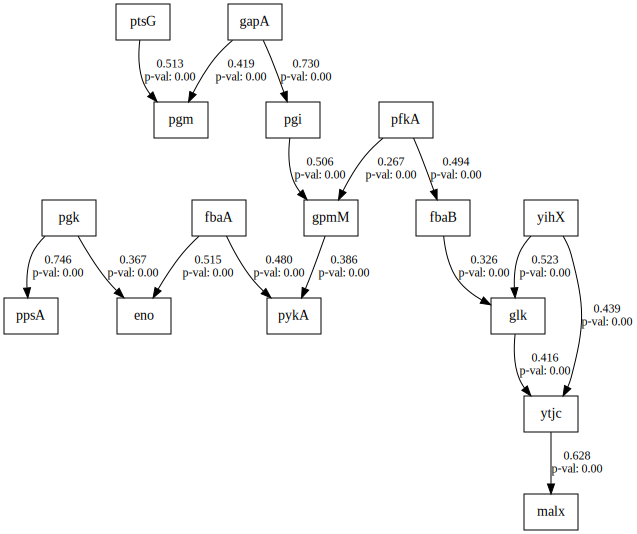

,number,RMSEA,lasso_beta,ridge_beta,threshold
4,4.0,0.12251,0.095204,0.023505,0.286611


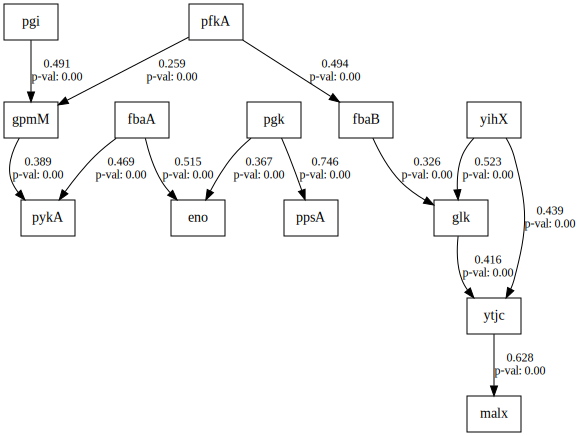

,number,RMSEA,lasso_beta,ridge_beta,threshold
1,1.0,0.14403,0.026046,0.011639,0.269675


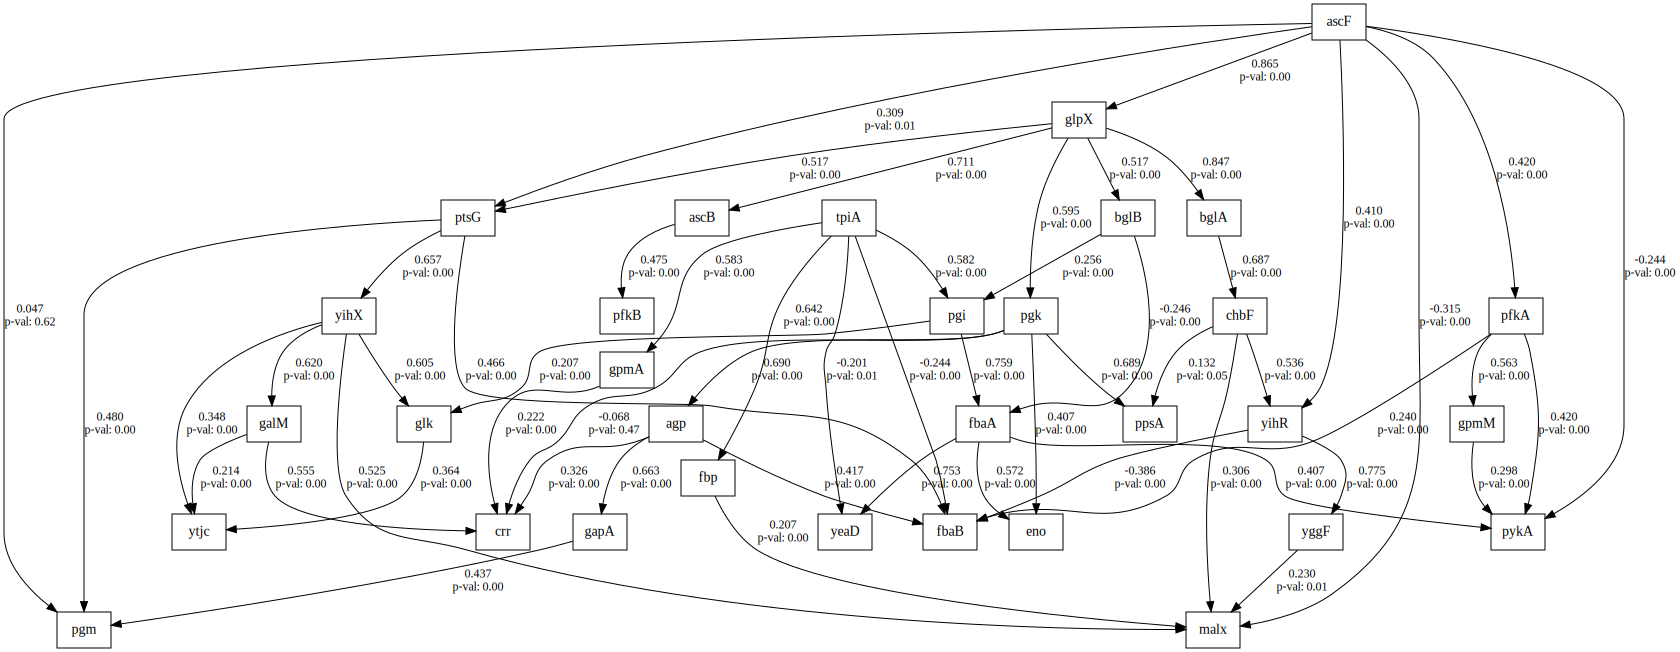

,number,RMSEA,lasso_beta,ridge_beta,threshold
3,3.0,0.14937,0.010935,0.033246,0.305568


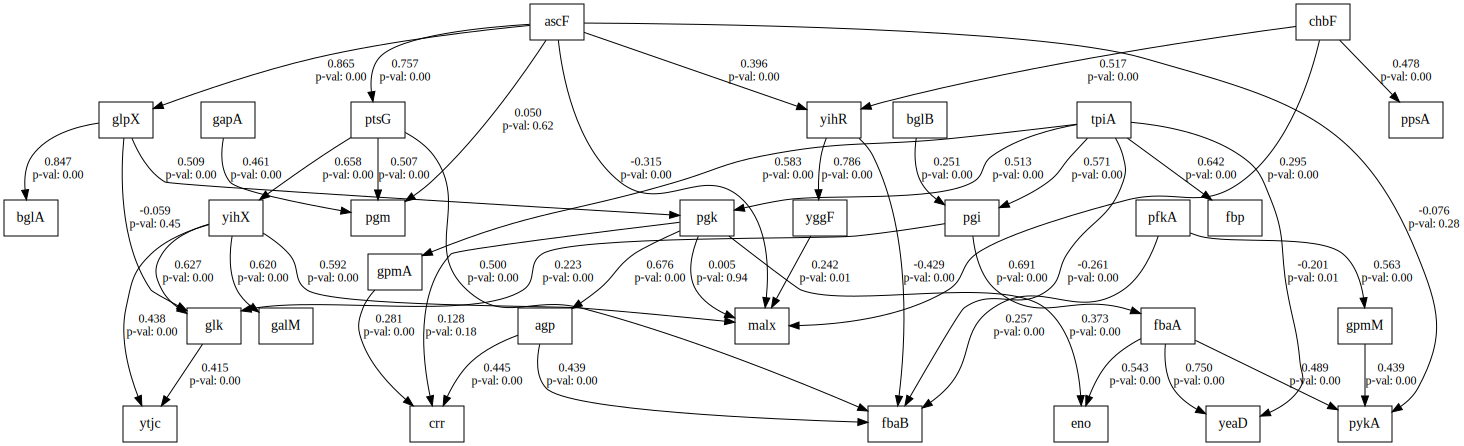

,number,RMSEA,lasso_beta,ridge_beta,threshold
0,0.0,0.18049,0.018543,0.075128,0.36629


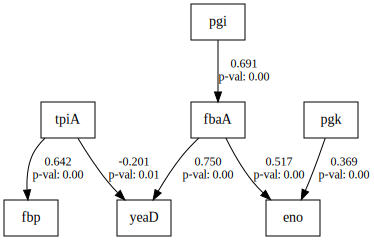

In [17]:
sem_plot(loaded_app, num=5)